In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
## Quick helper function
def is_ancestor(G,X,Y): #checks whether X is an ancestor of Y
    if X in nx.ancestors(G,Y):
        return(1)
    

In [1]:
## Helper function for find_case, checks for paths between targets and parents of conditions.
def check_paths(G,X,Y,cases):
    skeleton = G.to_undirected()
    y_ancestors = list(nx.ancestors(G,Y))
    paths = list(nx.all_simple_paths(skeleton, X, Y, cutoff=None)) #use skeleton so they are undirected (routes not paths).

    if len(y_ancestors) == 0:
        cases[Y] = "special" #Yj in TRIVIAL SPECIAL CASE
        return(cases)

    # The logic of the following is to find paths from X to Y: if any of them pass through an ancestor of Y
    # then there is a "back route" to Y through its ancestors, meaning there is a path connecting X to a(Y)
    # which does not pass through Y. 
    for path in paths:
        for y_ancestor in y_ancestors:
            if y_ancestor in path: #There exists a path from X to a(Y) which does not pass through Y
                cases[Y] = "general" #Yj IN GENERAL CASE
                return(cases)
            else:
                continue
            
    #Only reaches this block of code if all paths to a(Y) passed through Y; in nontrivial special case.
    cases[Y] = "special" #Yj IN SPECIAL CASE
    return(cases)


## Determine which case a query p(X|Ys) on a graph is in. Return the set of nodes the query depends on. 
def find_case(G,X,Ys): #Graph G, one target Xf, set of multiple conditions Ys = {y0, y1, ...}
    skeleton = G.to_undirected()
    dependent = []
    cases = {} #Dictionary with (key, value) pairs: (Y,case).
    if not nx.is_connected(skeleton): #Only consider connected graphs.
        return(0)
    
    if len(Ys) == 0:
        return(list(nx.ancestors(G,X)))
    
    for Y in Ys:
        cases = check_paths(G,X,Y,cases)
    
    shortest_path = nx.shortest_path(skeleton,X,Y) #use skeleton so we have shortest route (undirected)
    x_ancestors = list(nx.ancestors(G,X))
    y_ancestors = list(nx.ancestors(G,Y))
    
    dependent.append(X)
    for x_ancestor in x_ancestors:
        dependent.append(x_ancestor)

    for Y in Ys:
        if cases[Y] == "general":
            for node in shortest_path:
                dependent.append(node) ##Includes all nodes on shortest route form X to Y including X and Y. 
            for y_ancestor in y_ancestors:
                dependent.append(y_ancestor)
                
        if cases[Y] == "special":
            for node in shortest_path:
                dependent.append(node)
            dependent = list(set(dependent))
            dependent.remove(Y)
            for y_ancestor in y_ancestors:
                if y_ancestor in dependent:
                    dependent.remove(y_ancestor)
    
    return(list(set(dependent)))


In [4]:
## Return the set of covered edges in a graph. Independent of query. 
def find_covered_edges(G):
    covered_edges = []
    for edge in G.edges: #for edge (X,Y)
        source_parents = list(G.predecessors(edge[0])) #parents of X
        target_parents = list(G.predecessors(edge[1])) #parents of Y
        source_parents.append(edge[0]) #parents of X union X
        if set(source_parents) == set(target_parents):
            covered_edges.append(edge)
    return(covered_edges)


## Reverse chosen edge of a graph, return altered graph
def reverse_edge(G, edge):
    Grev = G.copy()
    Grev.add_edge(edge[1],edge[0])
    Grev.remove_edge(edge[0],edge[1])
    return(Grev)


## Given a query p(X|Ys), determine whether switching covered edge is advantageous,
## and return the number of vertices which no longer need to be computed given a possible switch
def is_advantageous(G,edge, X, Ys):
    vertex_cost_difference = 0
    cost_before = len(find_case(G, X, Ys))
    
    Grev = G.copy()
    Grev = reverse_edge(Grev,edge)
    cost_after = len(find_case(Grev,X,Ys))
    if cost_after < cost_before:
        vertex_cost_difference = cost_before - cost_after
    return(vertex_cost_difference)


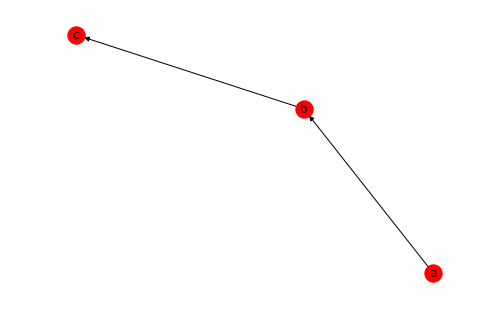

{('a', 'b'): 1}
('a', 'b')
{('a', 'b'): 1}


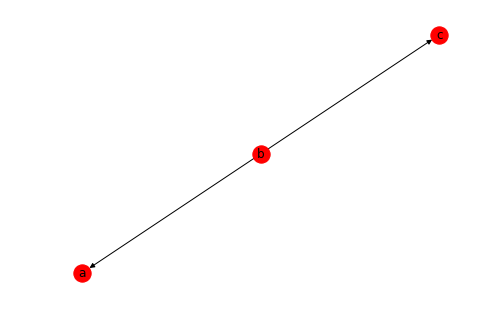

In [6]:
## Iterates through covered edges and returns the covered edge for which
## reversal reduces the number of vertices which must be computed MOST at a given time.
def best_reversal(G, X, Ys):
    covered_edges = find_covered_edges(G) 
    edge_advantages = {}
    for edge in covered_edges:
         edge_advantages[edge] = is_advantageous(G,edge,X,Ys)
    print(edge_advantages)
    max_adv_edge = max(edge_advantages, key=edge_advantages.get)
    return(max_adv_edge)

## Makes the most advantageous switch among covered edges at a given time. 
## (Not necessarily the sequence of overall best switches!)
def switch_best_reversal(G, X, Ys):
    print(best_reversal(G,X,Ys))
    Grev = G.copy()
    Grev = reverse_edge(Grev,best_reversal(Grev,X,Ys))
    return(Grev)


G1 = nx.DiGraph()
G1.add_edges_from([("a","b"),("b","c")])
nx.draw(G1, with_labels=True)
plt.show()

G1rev = switch_best_reversal(G1,"c",[])
nx.draw(G1rev, with_labels=True)
plt.show()

G2 [('a', 'b'), ('c', 'a')] 

{('a', 'b'): 0, ('c', 'a'): 0}
('a', 'b')
{('a', 'b'): 0, ('c', 'a'): 0}


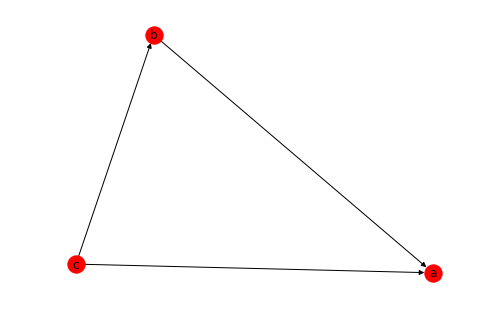

In [7]:
G2 = nx.DiGraph()
G2.add_edges_from([("a","b"),("c","a"),("c","b")])
print("G2", find_covered_edges(G2), "\n")

G2rev = switch_best_reversal(G2,"c",[])
nx.draw(G2rev, with_labels=True)
plt.show()

G3 [('a', 'c'), ('c', 'b')] 



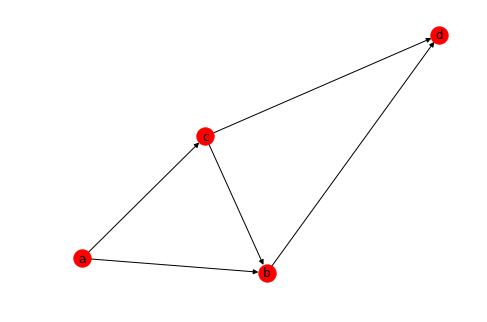

{('a', 'c'): 1, ('c', 'b'): 0}
('a', 'c')
{('a', 'c'): 1, ('c', 'b'): 0}


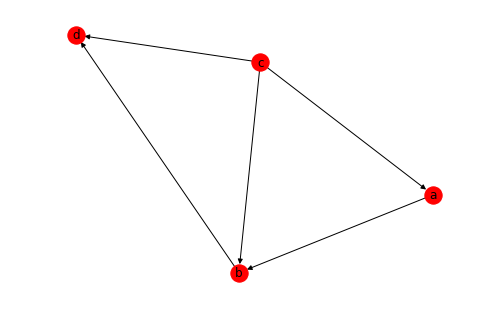

In [8]:
G3 = nx.DiGraph()
G3.add_edges_from([("a","b"),("a","c"),("c","b"),("c","d"),("b","d"),("c","b")])
print("G3", find_covered_edges(G3), "\n")
nx.draw(G3, with_labels=True)
plt.show()

G3rev = switch_best_reversal(G3,"c",[])
nx.draw(G3rev, with_labels=True)
plt.show()

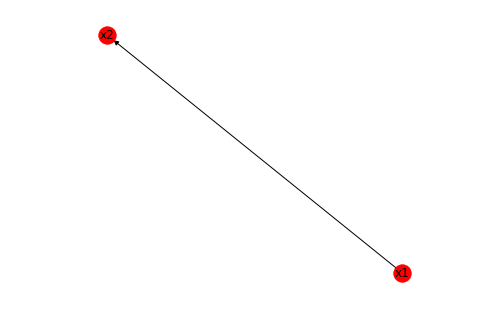

p(X2|X1): [[0.4 0.6]
 [0.2 0.8]] 

p(X1|X2): [[0.46153846 0.56756757]
 [0.23076923 0.75675676]]


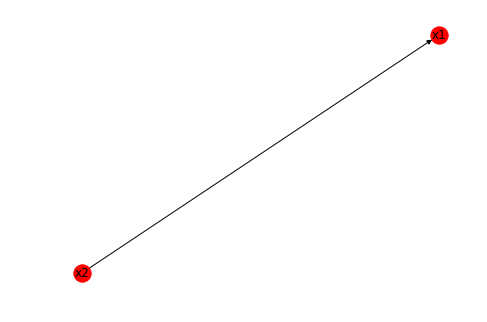

In [49]:
## Simple example of a network with two binary vertices x1 and x2, connected by (x1,x2). We encode the 
## conditional probabilities of each node in an embedded dictionary and recalculate after reversing the edge.

## Probability table
node_attr_list = [("x1",{
        "state_space":("0","1"),
        "parents":[],
        "dist":[.3,.7]}),
    ("x2",{
        "state_space":("0","1"),
        "parents":["x1"],
        "dist":{(("x1","1")):[.2,.8],
        (("x1","0")):[.4,.6]}})]
edge_list = [("x1","x2")]

G = nx.DiGraph()
G.clear()
G.add_edges_from(edge_list)
G.add_nodes_from(node_attr_list)
nx.draw(G, with_labels=True)
plt.show()

## Takes in a Bayesian network G and edge parameters (x1, x2), then returns a graph G_switched
## such that (x1, x2) is reversed to (x2, x1) and the joint probability function reflects the new
## representation of the Bayesian network
## Variable names are g=given, e=equals: p(A=a|B=b) --> pAeagBeb

def switch_edge_probs(G,x1,x2):
    px1 = G.node["x1"]["dist"] #p(X1)
    px2gx1e0 = np.array(G.node["x2"]["dist"][('x1','0')]) #p(X2|X1=0)
    px2gx1e1 = np.array(G.node["x2"]["dist"][('x1','1')]) #p(X2|X1=1)
    
    px1e0 = px1[0] #p(X1=1)
    px1e1 = px1[1] #p(X1=1)
    px2 = (px2gx1e1 * px1e1) + (px2gx1e0 * px1e0) #p(X2)
    px2gx1 = np.array([px2gx1e0, px2gx1e1]) #p(X2|X1)
    px1gx2 = (px2gx1 * px1)/(px2)
    print("p(X2|X1):", px2gx1, "\n")
    print("p(X1|X2):", px1gx2)
    
    # Sanity check
    px2x1 = px2 * px1gx2
    px1x2 = px1 * px2gx1
    # print(px1x2 == px2x1)
    
    new_node_attr_list = [("x2",{
        "state_space":("0","1"),
        "parents":[],
        "dist":
            px2}),
    ("x1",{
        "state_space":("0","1"),
        "parents":["x1"],
        "dist":
            {(("x2","1")):px1gx2[1],
            (("x2","0")):px1gx2[0]}})]
    new_edge_list = [("x2","x1")]
    
    G_switched = nx.DiGraph()
    G_switched.clear()
    G_switched.add_edges_from(new_edge_list)
    G_switched.add_nodes_from(new_node_attr_list)

    return(G_switched)

G_switched = switch_edge_probs(G,"x1","x2")
nx.draw(G_switched, with_labels=True)
plt.show()